# TP1

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## Lectura del dataset

Se reemplaza el atributo "Data of birth" por "Age" y encodeamos "Social Class" que va a ser la clase que queremos clasificar

In [2]:
def readCsv():
    df = pd.read_csv("FullData.csv")
    #df['Date of birth'] = pd.to_datetime(df['Date of birth'],format='%Y-%m-%d') 
    
    #Agregamos atributo edad
    df['Date of birth'] = pd.to_datetime('today').year - pd.to_datetime(df['Date of birth'],format='%Y-%m-%d').dt.year
    df = df.rename(columns={'Date of birth': 'Age' })
    
    #Encode social class
    socialClassEncoder = preprocessing.LabelEncoder()
    socialClassEncoder.fit(["AB", "C1", "C2", "D ", "E "])
    df['Social Class'] = socialClassEncoder.transform(df['Social Class'])
    
    return df

df = readCsv()

In [5]:

X=['Sex code', 'Age', 'Marital status', 'Household status',
       'Working status', 'Terminal age of education', 'Life stage',
       'Ethnic Origin', 'Disability', 'No of TV Sets', 'No of VCRs',
       'No of PVRs', 'No of DVDs', 'No of People', 'Social Class',
        'Demographic cell 1', 'Number of DVD Recorders',
       'Number of DVD Players', 'Number of Sky PVRs', 'Number of other PVRs',
       'Broadband', 'Mosaic Classification', 'Aire@Morning', 'Aire@Daytime',
       'Aire@Early Fringe', 'Aire@Late Fringe', 'Aire@Prime',
       'Aire@Late Night', 'Aire@Overnight', 'Cable@Morning', 'Cable@Daytime',
       'Cable@Early Fringe', 'Cable@Late Fringe', 'Cable@Prime',
       'Cable@Late Night', 'Cable@Overnight', 'Deportes@Morning',
       'Deportes@Daytime', 'Deportes@Early Fringe', 'Deportes@Late Fringe',
       'Deportes@Prime', 'Deportes@Late Night', 'Deportes@Overnight',
       'Infantil@Morning', 'Infantil@Daytime', 'Infantil@Early Fringe',
       'Infantil@Late Fringe', 'Infantil@Prime', 'Infantil@Late Night',
       'Infantil@Overnight']
y='Presence of Children'

In [16]:
df['Presence of Children']=[1 if df['Presence of Children'][i]!=1 else 0 for i in df.index]

In [19]:
# se instancia el modelo y se aplica a las variables seleccionadas
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(df[X],df[y])

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
pred=model.predict(df[X])

In [21]:
accuracy_score(df[y], pred)

0.8616732573466698

In [24]:
model.predict_proba(df[X])

array([[1.00000000e+000, 1.38839805e-020],
       [1.26321666e-124, 1.00000000e+000],
       [9.77951774e-001, 2.20482262e-002],
       ...,
       [9.99999999e-001, 6.57037677e-010],
       [1.48929851e-001, 8.51070149e-001],
       [9.99975853e-001, 2.41468287e-005]])

In [27]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(df[X], df[y])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [28]:
pred=model.predict(df[X])
accuracy_score(df[y], pred)

0.8616732573466698

In [30]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df[y], pred)

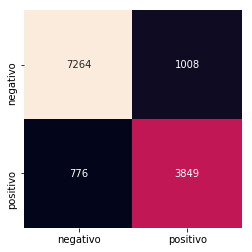

In [32]:
import seaborn as sns
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['negativo','positivo'], yticklabels=['negativo','positivo'])

## Caso 1: Social Class

No se consigue un buen resultado así como están los datos.

In [ ]:
def train(df, targetColumn, depth):
    features = list(df.columns)
    features.remove(targetColumn)
    
    y = df[targetColumn]
    X = df[features]

    classes = df[targetColumn].unique()
    #Split for train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=123)

    #Se construye el modelo utilziando DecisionTreeClassifier y con fit se ajusta este modelo al conjunto de entrenamiento
    dt = DecisionTreeClassifier(max_depth=3, min_samples_split=3)
    dt.fit(train_X, train_y)

    # Con prediction calculo mi modelo con el conjunto de test de manera de medir qué el comportamkiento sonbre este conjunto
    predictions = dt.predict(test_X)

    #Y posteriormente con accuracy veo la bondad de ajuste sobre el test
    acc = accuracy_score(test_y, predictions)

    return dt, acc, features, classes

dt, acc, features, classes = train(df, "Social Class", 3)
print("Feature Set: ", features)
print("Classes: ", classes)
print("Accuracy: ", acc)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Caso 2: Social Class con porcentajes de tiempo y tiempo total

La otra que probé fue agregar un total time y cambiar los itempo por porcentajes. El resultado fue el mismo, parece que no le importa nada las horas de televisión al árbol.

In [ ]:
def encodeHour(df, replaceForPercentage):    
    df['Total Time'] = 0
    timeColumns = (list(df.columns[30:50]))
    for time in timeColumns:
        df['Total Time'] = df['Total Time'] + df[time]

    if replaceForPercentage:
        for time in timeColumns:
            df[time] = df[time].divide(df['Total Time']) * 100

        df.replace(np.Inf, 0)
    
    return df

df = readCsv()
df = encodeHour(df, True)

dt, acc, features, classes = train(df, "Social Class", 3)
print("Feature Set: ", features)
print("Classes: ", classes)
print("Accuracy Social Class: ", acc)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Caso 3: Sex code

Probé a ver como funciona el modelo con Sex Code y creo que da cerca del valor que estabamos viendo el otro día en clase. Parece que al árbol le importa Genre Sport para clasificar al  menos.

In [ ]:
df = readCsv()
df = encodeHour(df, True)

dt, acc, features, classes = train(df, "Sex code", 3)
print("Feature Set: ", features)
print("Classes: ", classes)
print("Accuracy: ", acc)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Caso 4: Sex code sin el cambio de las horas

Si no hago lo de las horas anda un poco mejor esto

In [ ]:
df = readCsv()
df = encodeHour(df, False) #Solo agrego las horas totales

dt, acc, features, classes = train(df, "Sex code", 3)
print("Feature Set: ", features)
print("Classes: ", classes)
print("Accuracy: ", acc)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Caso 5: Agrupar "Social Class" en 2 grupos

Viendo un poco la definición de Social Class (https://en.wikipedia.org/wiki/NRS_social_grade) aparentemente una forma popular de hacer esto es por ABC1 y C2DE, que separa entre middle class y working class. Se llega a una accuracy de 0.68, es algo al menos. 

In [ ]:
def groupSocialClassCondition(x):
    if x == 0 or x == 1:
        return 0
    else:
        return 1

def groupSocialClass(df):
    df['Social Class'] = df['Social Class'].apply(groupSocialClassCondition)
    return df

df = readCsv()
#df = encodeHour(df, True)
df = groupSocialClass(df)

dt, acc, features, classes = train(df, "Social Class", 3)
print("Feature Set: ", features)
print("Classes: ", classes)
print("Accuracy: ", acc)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())